# Introduction

This tutorial describes how to use Ivy to synthesize a valid, high-quality instrumental variable (IV) from a set of IV candidates that are potentially dependent on each other and invalid. The synthesized IV can then be used for downstream to estimate the causal  effect from a risk factor to an outcome. The tutorial is organized as follows:

* **A Primer on Causal Inference, IVs, and Ivy**: Causal inference gurus and IV experts should feel free to skip this section!

* **Generate Synthetic Data**: We generate risk factor and outcome data from a spurious (non-causal) relationship along with data of IV candidates that are potentially dependent on each other and invalid.

* **Instrumental Variable Synthesis**: This section has two steps. First, we identify the subset of IV candidates that are valid and their dependencies. Second, we harness the subset of valid IVs and their dependencies to synthesize a valid, high-quality IV.

* **Causal Effect Estimation**: We use the synthesized IV from the previous step to estimate causal effects.

# A Primer on Causal Inference, IVs, and Ivy

We introduce related concepts in causal inference, instrumental variables, and Ivy. <font color=red>Causal inference gurus and IV experts should feel free to skip this section!</font>

* **Causal Inference**: A goal in causal inference is to estimate the causal effect between the risk factor $x$ and the outcome $y$. This effect is challenging to estimate from observational data because it is usually obscured by a confounder $c$, the common cause of the risk factor and the outcome. The observational correlation between a non-causal pair of $x$ and $y$ due to $c$ is known as spurious correlation (spurious relationship).

* **Instrumental Variables (IVs)**: An IV $z$ is defined as a variable that influences the risk factor independently of the confounder and influences the outcome only through the risk factor (i.e. $z$ satisfies: $z\not\perp x$, $z \perp c$, and $z \perp y \mid c, x$). A variable that does not meet the IV definition is known as an invalid IV. When available in observational data, an IV can be used to estimate causal effects even where there are unmeasured confounders. Below is an illustration of how $z$,  $x$, $y$, and $c$ (unmeasured) are related to each other:

<img src="./support/iv.png" style="width:25%"/>

* **IV Candidates**: In many real-world scenarios, valid high-quality IVs are usually not available. Instead, practitioners make use of more widely available IV candidates that could potentially serve as IVs. Unfortunately, IV candidates can be statistically dependent on each other, or even be invalid IVs. Naively treating candidates as valid IVs without addressing dependencies and invalidity among them leads to unreliable causal estimates.

* **Instrumental Variable Synthesis (Ivy)**: To handle IV candidates, Ivy considers synthesizing a valid IV of high quality from a set of IV candidates that are potentially dependent on each other and invalid. Once such a valid high-quality IV is synthesized, it can be plugged into existing downstream IV-based causal effect estimators for causal inference.

Below is an illustration of the valid, high-quality IV $z$ and six IV candidates ($w_1$-$w_6$). $w_1$-$w_3$ are valid IVs and $w_4$-$w_6$ are invalid IVs. Note that $w_4$ is invalid because $w_4 \not\perp c$, $w_5$ is invalid because $w_5 \not\perp y \mid x,c$, and $w_6$ is invalid because $w_6 \not\perp y \mid x,c$ and $w_6 \perp x$.  $w_2$ and $w_3$ are also dependent on each other. $z$ is considered unobserved by Ivy. Ivy first infers the subset of valid IVs and the dependencies among them. It then uses this information to infer the value of $z$ (i.e. $p(z \mid w_1, w_2, w_3)$).

<img src="./support/iv-candidates.png" style="width:25%"/>

# Initialization

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir
from utils.data_simulator import DataSimulator
import numpy as np
import pandas as pd
from methods.ivy import Ivy
import random
from utils.utils import get_f1, summary
from sklearn.metrics import roc_auc_score
from estimators.prob_wald_estimator import ProbWaldEstimator
from estimators.compute_causality import ComputeCausality
import multiprocessing

# Generate Synthetic Data

We start by generating some synthetic data. Here, we consider an example where the ground truth is a positive spurious (non-causal) correlation between a risk factor and an outcome. We consider a realistic scenario where among the IV candidates there are `p` valid IVs and `q` invalid IVs. Furthermore, there are dependencies between the valid IVs. All the invalid IVs here are conditionally independent given the confounder. We first specify a data generation model (`mdl`), where, without loss of generality, we assume that the first `p` IV candidates are valid IVs and the following `q` IV candidates are invalid IVs. We then generate `n` samples of synthetic data from the model. The synthetic data generated are as follows:
* `z`: a `numpy.ndarray` of shape `(n,)`, it contains the data of the valid, high-quality IV that Ivy seeks to synthesize without observing its value. We provide it here as ground truth for subsequent validation purposes.
* `IVs`: a `numpy.ndarray` of shape `(n,p+q)`, it is the data matrix of IV candidates with the first `p` columns being data of the valid IVs and the following `q` columns being data of the invalid IVs.
* `x`: a `numpy.ndarray` of shape `(n,)`, it contains the risk factor data.
* `y` a `numpy.ndarray` of shape `(n,)`, it contains the outcome data.

In [2]:
# for reproducibility
seed = 0
np.random.seed(seed)
random.seed(seed)

# number of valid IVs
p = 10

# are there dependencies within valid IVs?
cond_indp = False

# max degree of dependencies
d = 5

# number of invalid IVs
q = 8

# number of samples
n = 80000

# create a DataSimulator instance
mdl = DataSimulator(p,cond_indp=cond_indp,d=d,q=q,seed=seed)

# sample synthetic data from mdl
z, IVs, x, y = mdl.get_samples(n=n)

Since we are particularly interested in identifying the subset of valid IVs and their dependencies, let's see how the `p` valid IVs are connected to each other and to the high-quality valid IV `z`:

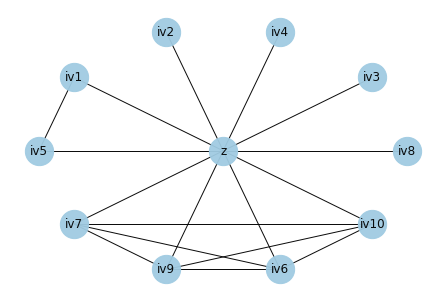

In [3]:
mdl.iv_mdl.draw_graph()

# Instrumental Variable Synthesis (Ivy)

With the data prepared, we can run Ivy! Ivy takes a `n*(p+q)` data matrix of IV candidates as input, and outputs a synthesized IV `z_hat` of shape `(n,)`. We briefly describe the algorithmic procedure of Ivy:

* **Learning Dependencies and Validity**: Ivy takes all the IV candidates as input to compute a sample covariance matrix. This matrix is decomposed in a robust PCA fashion in order to estimate the validity and dependencies of the IV candidates. 

* **Synthesize a High-quality IV**: Ivy then learns a model that estimates the value of the desired, valid, high-quality IV given the subset of valid IVs and dependencies learned from the previous step.

## Learning Dependencies and Validity

Here we learn the dependencies and validity among  the IV candidates directly from the data. The algorithm takes the IV candidate matrix (IVs) as input and outputs a sparse matrix (`S`) that encodes dependencies and an accuracy vector (`l`) that indicates how predictive an IV candidate is to the value of `z`. 

We can read off the sparsity pattern in `S` as the dependencies among IV candidates and choose the subset of IV candidates that have high enough accuracy in predicting `z` as valid IVs.

In [4]:
# create an Ivy model
ivy = Ivy()

# learn the accuracy vector l and dependency matrix S
l, S, _ = ivy.dependency_validity(IVs/2)

# thresholding l in a data-dependent hyperparameter-free fashion to get the valid IVs
valid_indx = ivy.get_valid_iv_indx(l)

# create the submatrix of valid IVs
IVs_valid = IVs[:,valid_indx]

# thresholding S in a data-dependent hyperparameter-free fashion to get the dependencies among IV candidates
deps = ivy.get_dependencies(S)
deps_valid = [x for x in deps if (int(x[0]) in valid_indx) and (int(x[1]) in valid_indx)]

iteration: 1, error: 18.521687712894852
iteration: 7120, error: 3.052496274111308e-05


Let's see how well Ivy performed at recovering the dependencies and valid IVs among IV candidates:

In [ ]:
print(f"F1 score of recovering dependencies: {get_f1(deps_valid,mdl.iv_mdl.dependency):.3f}")
print(f"F1 score of recovering valid IVs: {get_f1(valid_indx,list(range(p))):.3f}")

## Synthesize a High-quality IV

Now that we have learned the subset of valid IVs and their dependencies, we are ready to synthesize a high-quality IV (`z_hat`) from the candidates that are valid IVs and their dependencies!

In [ ]:
# train an Ivy model
# use_canonical: if True, we map the mean parameters of a graphical model 
# to the canonical parameters for subsequent inference of the model
use_canonical = True if len(deps_valid) else False
ivy.train(IVs_valid, deps=deps_valid, use_canonical=use_canonical)

# infer the probability of z=1 for a given configuration of valid IVs
z_hat = ivy.predict_proba(IVs_valid)

With both the ground truth `z` and the corresponding estimation `z_hat` given by Ivy, we can evaluate how well `z_hat` recovers `z` by the area under the receiver operating characteristic curve (AUROC):

In [ ]:
print(f"AUROC of z_hat predicting z: {roc_auc_score(z,z_hat):.5f}")

# Causal Effect Estimation

With the synthesized IV (or equivalently, the subset of valid IVs and their dependencies learned by Ivy), we are now ready to estimate causal effect! To this end, we first plug the data of the synthesized IV, along with the data from the risk factor and the outcome, into an existing causal effect estimator to estimate causal effects. We then describe the metric that we use to draw a causal conclusion.

* **Causal Effect Estimator**: We will use a classic estimator called the Wald estimator weighted by the probability of z=1 to compute causal effect (`ProbWaldEstimator`). Since we are considering a spurious relationship, we expect a good causal effect estimate to be close to zero. 
* **Metric**: We will randomly subsample the dataset 100 times in parallel in order to derive the median and the 95% confidence interval (c.i.) of the causal estimate. We examine how close a median is to zero as a metric to measure biasedness and whether the c.i. includes zero to conclude whether the algorithm can successfully dismiss spurious relationships.

In [ ]:
%%time
method_list = [Ivy]
estimator_list = [ProbWaldEstimator]
n_trial = 100
random_seed = range(n_trial)
# you can always set num_cores=1 to not do subsampling in parallel. 
num_cores = multiprocessing.cpu_count()

# estimate causal effect
wald_ratio = ComputeCausality(x, y, IVs_valid, method_list, estimator_list, 
    n_trial=n_trial, random_seed=random_seed, deps=[(int(x[0]),int(x[1])) for x in deps_valid],
    num_cores=num_cores, use_canonical=use_canonical)

# metirc
wald_ratio_summary_df = pd.DataFrame(np.transpose(summary(wald_ratio)),columns=["ci_lower","ci_upper","median"])
print(round(wald_ratio_summary_df,3))

The confidence interval of the causal effect estimate should cover zero since the ground truth is that there is no causal relationship. If so, congratulations! You just used Ivy to synthesize an instrumental variable to successfully estimate causal effect! 